# Boston Housing Predict

For this notebook, I am going to build and test data from the Boston Housing dataset on Kaggle.

* https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset

The purpose of the Boston Housing dataset is to utilize a regression model to predict the median value for houses in Boston.

## Setup

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

Additionally, if on google colab, then I will need to install my personal repository, [py-learning-toolbox](https://github.com/bkubick/py-learning-toolbox) as a package.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [2]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

## Imports

In [3]:
import datetime
import logging
import random
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import ml_toolbox
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow_model_optimization as tfmot

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [4]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-10-08 14:55:01.187885


In [5]:
tf.__version__

'2.13.0'

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [8]:
RANDOM_SEED = 27

## Helpers 
Defining helper functions to split certain functionality out of tasks.

In [9]:
ActivationType = typing.Union[str, typing.Callable[[tf.Tensor], tf.Tensor]]

class SkipConnectionDenseLayer(tf.keras.layers.Layer):

    def __init__(self,
                 units: int = 32,
                 hidden_layers: int = 1,
                 activation: typing.Optional[ActivationType] = None,
                 *args,
                 **kwargs):
        """ Skip connection dense layer.

            Args:
                units (int): the number of units in the layer.
                hidden_layers (int): the number of hidden layers in the layer.
                activation (Optional[ActivationType]): the activation function to use.
        """
        super().__init__(*args, **kwargs)
        activation = activation or 'relu'
        self.hidden_layers = [tf.keras.layers.Dense(units, activation=activation) for _ in range(hidden_layers)]
        self.sum_layer = tf.keras.layers.Add()

    def call(self, inputs: tf.Tensor, *args, **kwargs) -> tf.Tensor:
        """ Forward pass of the layer.

            Args:
                inputs (tf.Tensor): the input tensor to the layer.

            Returns:
                (tf.Tensor) the output of the layer.
        """
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.sum_layer([inputs, x])
        return x

## Downloading, Analyzing, & Creating Datasets

The data used in the paper is publicly available through the TensorFlow API directly.

* https://www.tensorflow.org/api_docs/python/tf/keras/datasets/boston_housing
* http://lib.stat.cmu.edu/datasets/boston

Features:
* CRIM     per capita crime rate by town
* ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS    proportion of non-retail business acres per town
* CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX      nitric oxides concentration (parts per 10 million)
* RM       average number of rooms per dwelling
* AGE      proportion of owner-occupied units built prior to 1940
* DIS      weighted distances to five Boston employment centres
* RAD      index of accessibility to radial highways
* TAX      full-value property-tax rate per \$10,000
* PTRATIO  pupil-teacher ratio by town
* B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT    % lower status of the population
* MEDV     Median value of owner-occupied homes in \$1000's

### Data Constants

In [10]:
# Constants
TEST_SPLIT = 0.2

VARIABLE_NAMES = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT',
    'MEDV',
]

### Download & Split Data

In [11]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=TEST_SPLIT, seed=RANDOM_SEED)

len(X_train), len(y_train), len(X_test), len(y_test)

(404, 404, 102, 102)

### Analyze Data

In [12]:
train_df = pd.DataFrame(tf.concat([X_train, y_train.reshape((-1,1))], axis=1), columns=VARIABLE_NAMES)
test_df = pd.DataFrame(tf.concat([X_test, y_test.reshape((-1,1))], axis=1), columns=VARIABLE_NAMES)
train_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,37.66190,0.0,18.10,0.0,0.679,6.202,78.7,1.8629,24.0,666.0,20.2,18.82,14.52,10.9
1,0.54011,20.0,3.97,0.0,0.647,7.203,81.8,2.1121,5.0,264.0,13.0,392.80,9.59,33.8
2,0.17134,0.0,10.01,0.0,0.547,5.928,88.2,2.4631,6.0,432.0,17.8,344.91,15.76,18.3
3,38.35180,0.0,18.10,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0
4,1.19294,0.0,21.89,0.0,0.624,6.326,97.7,2.2710,4.0,437.0,21.2,396.90,12.26,19.6


In [13]:
X_train.shape, y_train.shape

((404, 13), (404,))

In [14]:
X_train[0], y_train[0]

(array([ 37.6619,   0.    ,  18.1   ,   0.    ,   0.679 ,   6.202 ,
         78.7   ,   1.8629,  24.    , 666.    ,  20.2   ,  18.82  ,
         14.52  ]),
 10.9)

In [15]:
train_df[['ZN', 'CHAS']].value_counts()

ZN     CHAS
0.0    0.0     275
       1.0      25
80.0   0.0      12
20.0   0.0      12
12.5   0.0      10
22.0   0.0       9
25.0   0.0       9
30.0   0.0       4
45.0   0.0       4
40.0   0.0       4
60.0   0.0       3
95.0   0.0       3
90.0   0.0       3
21.0   0.0       3
40.0   1.0       3
75.0   0.0       3
70.0   0.0       2
85.0   0.0       2
82.5   0.0       2
28.0   0.0       2
33.0   0.0       2
55.0   0.0       2
20.0   1.0       2
35.0   0.0       2
34.0   0.0       2
18.0   0.0       1
52.5   0.0       1
90.0   1.0       1
100.0  0.0       1
Name: count, dtype: int64

In [16]:
X_train[0]

array([ 37.6619,   0.    ,  18.1   ,   0.    ,   0.679 ,   6.202 ,
        78.7   ,   1.8629,  24.    , 666.    ,  20.2   ,  18.82  ,
        14.52  ])

### Preprocess Data

After analyzing the data, it is apparent I need to do some scaling on non-categorical data.

In [17]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train_df[train_df.columns.difference(['CHAS', 'MEDV'])])

train_transformed_less_chas = min_max_scaler.transform(train_df[train_df.columns.difference(['CHAS', 'MEDV'])])
test_transformed_less_chas = min_max_scaler.transform(test_df[test_df.columns.difference(['CHAS', 'MEDV'])])

X_train_scaled = tf.concat([train_transformed_less_chas, X_train[:, 3].reshape((-1, 1))], axis=1)
X_test_scaled = tf.concat([test_transformed_less_chas, X_test[:, 3].reshape((-1, 1))], axis=1)

X_train_scaled[3], X_test_scaled[3]

(<tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([1.        , 1.        , 0.43099395, 0.0327365 , 0.64662757,
        0.8187234 , 0.63374486, 0.80851064, 1.        , 0.36252156,
        0.91412214, 0.        , 0.        ])>,
 <tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([0.15962925, 0.96648848, 0.00097044, 0.39666633, 0.2063783 ,
        0.19687943, 0.09876543, 0.37234043, 0.26086957, 0.56217666,
        0.27099237, 0.34      , 0.        ])>)

### Create Datasets

In [18]:
X_train_scaled[3], y_train[3]

(<tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([1.        , 1.        , 0.43099395, 0.0327365 , 0.64662757,
        0.8187234 , 0.63374486, 0.80851064, 1.        , 0.36252156,
        0.91412214, 0.        , 0.        ])>,
 5.0)

In [19]:
train_dataset = data_toolbox.generate_dataset_from_data([X_train_scaled], y_train)
test_dataset = data_toolbox.generate_dataset_from_data([X_test_scaled], y_test)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float64, name=None),), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float64, name=None),), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

## Experiments

* Experiment-0: Simple Feed Forward
* Experiment-1: Simple Feed Forward w/ Non-linear Activation
* Experiment-2: Deep NN w/ Non-linear Activation
* Experiment-3: Skip Connection Model w/ Non-linear Activation
* Experiment-4: Deep NN w/ Pruning and Non-linear Activation
* Experiment-5: Learning Rate Analysis of Pruned DNN
* Experiment-6: Pruned Deep Neural Network, Optimized Learning Rate, w/ Non-Linear Activation

### Constants

In [20]:
INPUT_SIZE = 13
OUTPUT_SIZE = 1

### Experiment-0: Simple Feed Forward

In [21]:
# Constants
model_0_name = 'model_0_simple'

In [22]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

model_0 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SIZE,)),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(OUTPUT_SIZE),
], name=model_0_name)

model_0.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

model_0_history = model_0.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=100)

Epoch 1/100
13/13 [==============================] - 0s 6ms/step - loss: 21.4141 - mae: 21.4141 - mse: 547.6685 - val_loss: 21.8608 - val_mae: 21.8608 - val_mse: 555.9282
Epoch 2/100
13/13 [==============================] - 0s 958us/step - loss: 20.9086 - mae: 20.9086 - mse: 527.3206 - val_loss: 21.3710 - val_mae: 21.3710 - val_mse: 535.5512
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 20.3851 - mae: 20.3851 - mse: 506.8058 - val_loss: 20.8613 - val_mae: 20.8613 - val_mse: 514.8706
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 19.8383 - mae: 19.8383 - mse: 485.9821 - val_loss: 20.3266 - val_mae: 20.3266 - val_mse: 493.7574
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 19.2628 - mae: 19.2628 - mse: 464.7411 - val_loss: 19.7621 - val_mae: 19.7621 - val_mse: 472.1071
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 18.6562 - mae: 18.6562 - mse: 443.0093 - val_loss: 19.1649 - val_mae: 

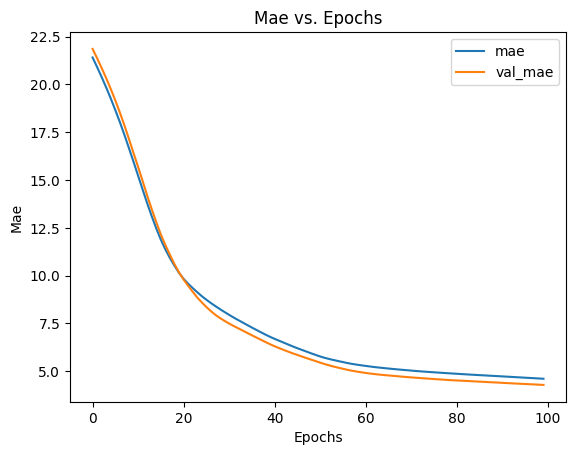

In [23]:
ml_toolbox.analysis.history.plot_history(model_0_history, 'mae')

In [24]:
model_0_preds = model_0.predict(test_dataset)

model_0_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_test, tf.squeeze(model_0_preds), model_0_name)
model_0_results

4/4 [==============================] - 0s 912us/step


RegressionPredictionMetrics(mae=4.2856345, mse=40.74713, rmse=6.383348, mape=17.530329, mase=0.44711193, huber=3.8165414, name='model_0_simple')

### Experiment-1: Simple Feed Foward w/ Non-Linear Activation

In [25]:
# Constants
model_1_name = 'model_1_single_hidden_relu'

In [26]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SIZE,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SIZE),
], name=model_1_name)

model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

model_1_history = model_1.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=100)

Epoch 1/100
13/13 [==============================] - 0s 5ms/step - loss: 21.7461 - mae: 21.7461 - mse: 561.0698 - val_loss: 22.2502 - val_mae: 22.2502 - val_mse: 572.4849
Epoch 2/100
13/13 [==============================] - 0s 876us/step - loss: 21.4058 - mae: 21.4058 - mse: 547.1974 - val_loss: 21.9366 - val_mae: 21.9366 - val_mse: 559.2617
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 21.0775 - mae: 21.0775 - mse: 534.0664 - val_loss: 21.6281 - val_mae: 21.6281 - val_mse: 546.4988
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 20.7529 - mae: 20.7529 - mse: 521.3111 - val_loss: 21.3209 - val_mae: 21.3209 - val_mse: 533.9938
Epoch 5/100
13/13 [==============================] - 0s 977us/step - loss: 20.4264 - mae: 20.4264 - mse: 508.6900 - val_loss: 21.0106 - val_mae: 21.0106 - val_mse: 521.5121
Epoch 6/100
13/13 [==============================] - 0s 948us/step - loss: 20.0939 - mae: 20.0939 - mse: 496.0349 - val_loss: 20.6921 - val_m

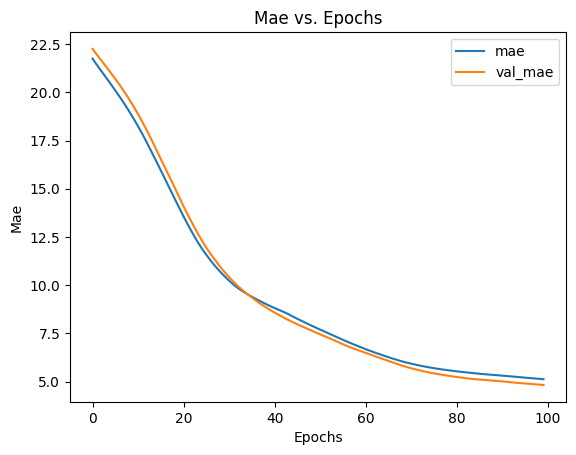

In [27]:
ml_toolbox.analysis.history.plot_history(model_1_history, 'mae')

In [28]:
model_1_preds = model_1.predict(test_dataset)

model_1_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_test, tf.squeeze(model_1_preds), model_1_name)
model_1_results

4/4 [==============================] - 0s 1ms/step


RegressionPredictionMetrics(mae=4.823767, mse=52.500267, rmse=7.245707, mape=19.291233, mase=0.5032543, huber=4.363771, name='model_1_single_hidden_relu')

### Experiment-2: Deep Neural Net w/ Non-Linear Activation

In [29]:
# Constants
model_2_name = 'model_2_deep_net'

NUM_HIDDEN_LAYERS_2 = 15
NUM_NEURONS_PER_HIDDEN_2 = 32

In [30]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,))

x = inputs
for _ in range(NUM_HIDDEN_LAYERS_2):
    x = tf.keras.layers.Dense(NUM_NEURONS_PER_HIDDEN_2, activation='relu')(x)

outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='relu')(x)

model_2 = tf.keras.models.Model(inputs, outputs, name=model_2_name)

model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

model_2_history = model_2.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=100)

Epoch 1/100
13/13 [==============================] - 0s 8ms/step - loss: 22.3317 - mae: 22.3317 - mse: 585.2084 - val_loss: 22.8868 - val_mae: 22.8868 - val_mse: 599.5253
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 21.7650 - mae: 21.7650 - mse: 560.4097 - val_loss: 21.2249 - val_mae: 21.2249 - val_mse: 527.0303
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 15.2171 - mae: 15.2171 - mse: 332.2809 - val_loss: 8.3548 - val_mae: 8.3548 - val_mse: 110.5847
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 9.5131 - mae: 9.5131 - mse: 147.5187 - val_loss: 8.7011 - val_mae: 8.7011 - val_mse: 129.8844
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 7.8017 - mae: 7.8017 - mse: 106.0310 - val_loss: 6.4924 - val_mae: 6.4924 - val_mse: 74.8006
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 6.8877 - mae: 6.8877 - mse: 88.7693 - val_loss: 5.7791 - val_mae: 5.7791 - val_mse:

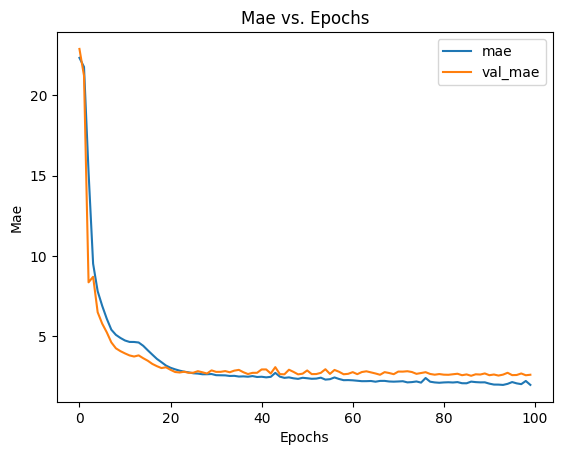

In [31]:
ml_toolbox.analysis.history.plot_history(model_2_history, 'mae')

In [32]:
model_2_preds = model_2.predict(test_dataset)

model_2_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_test, tf.squeeze(model_2_preds), model_2_name)
model_2_results

4/4 [==============================] - 0s 749us/step


RegressionPredictionMetrics(mae=2.6009755, mse=15.6035185, rmse=3.950129, mape=11.599134, mase=0.27135473, huber=2.1656842, name='model_2_deep_net')

### Experiment-3: Skip Neural Network w/ Non-Linear Activation

In [33]:
# Constants
model_3_name = 'model_3_skip_nn'

In [34]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,))
x = tf.keras.layers.Dense(64)(inputs)
x = SkipConnectionDenseLayer(64, hidden_layers=6)(x)
x = tf.keras.layers.Dense(32)(inputs)
x = SkipConnectionDenseLayer(32, hidden_layers=6)(x)
x = tf.keras.layers.Dense(16)(inputs)
x = SkipConnectionDenseLayer(16, hidden_layers=6)(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='relu')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name=model_3_name)

model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

model_3_history = model_3.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=100)

Epoch 1/100
13/13 [==============================] - 0s 6ms/step - loss: 22.0486 - mae: 22.0486 - mse: 574.5242 - val_loss: 22.5055 - val_mae: 22.5055 - val_mse: 583.7437
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 21.2343 - mae: 21.2343 - mse: 541.1195 - val_loss: 21.3232 - val_mae: 21.3232 - val_mse: 533.6605
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 19.5456 - mae: 19.5456 - mse: 475.5168 - val_loss: 19.0065 - val_mae: 19.0065 - val_mse: 443.6441
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 16.1454 - mae: 16.1454 - mse: 358.4105 - val_loss: 14.0960 - val_mae: 14.0960 - val_mse: 281.6414
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 10.9793 - mae: 10.9793 - mse: 193.7941 - val_loss: 8.8786 - val_mae: 8.8786 - val_mse: 126.1223
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 9.3411 - mae: 9.3411 - mse: 137.6788 - val_loss: 8.2488 - val_mae: 8.2488 

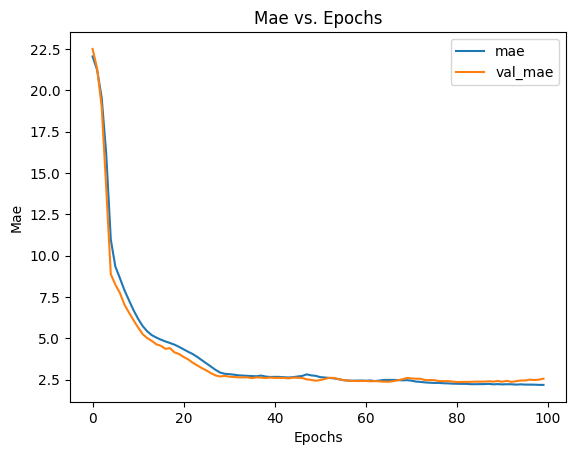

In [35]:
ml_toolbox.analysis.history.plot_history(model_3_history, 'mae')

In [36]:
model_3_preds = model_3.predict(test_dataset)

model_3_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_test, tf.squeeze(model_3_preds), model_3_name)
model_3_results

4/4 [==============================] - 0s 974us/step


RegressionPredictionMetrics(mae=2.5583518, mse=12.519767, rmse=3.5383282, mape=11.712883, mase=0.26690787, huber=2.1078706, name='model_3_skip_nn')

### Experiment-4: Pruned Deep Neural Network w/ Non-Linear Activation

In [37]:
# Constants
model_4_name = 'model_4_pruned_dnn'

In [38]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,))

x = inputs
for _ in range(NUM_HIDDEN_LAYERS_2):
    x = tfmot.sparsity.keras.prune_low_magnitude(tf.keras.layers.Dense(NUM_NEURONS_PER_HIDDEN_2, activation='relu'))(x)

outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='relu')(x)

model_4 = tf.keras.models.Model(inputs, outputs, name=model_4_name)

model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

model_4_history = model_4.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=100,
                              callbacks=[
                                 tfmot.sparsity.keras.UpdatePruningStep(),
                                 tfmot.sparsity.keras.PruningSummaries(log_dir='./logs/pruning/')
                              ])

Epoch 1/100
13/13 [==============================] - 3s 13ms/step - loss: 22.3317 - mae: 22.3317 - mse: 585.2084 - val_loss: 22.8868 - val_mae: 22.8868 - val_mse: 599.5253
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 21.7650 - mae: 21.7650 - mse: 560.4097 - val_loss: 21.2249 - val_mae: 21.2249 - val_mse: 527.0303
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 15.2171 - mae: 15.2171 - mse: 332.2809 - val_loss: 8.3548 - val_mae: 8.3548 - val_mse: 110.5847
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 9.5131 - mae: 9.5131 - mse: 147.5187 - val_loss: 8.7011 - val_mae: 8.7011 - val_mse: 129.8844
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 7.8017 - mae: 7.8017 - mse: 106.0310 - val_loss: 6.4924 - val_mae: 6.4924 - val_mse: 74.8006
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 6.8877 - mae: 6.8877 - mse: 88.7693 - val_loss: 5.7791 - val_mae: 5.7791 - val_mse

In [39]:
# Uncomment below to upload the 
# !tensorboard --logdir logs/pruning

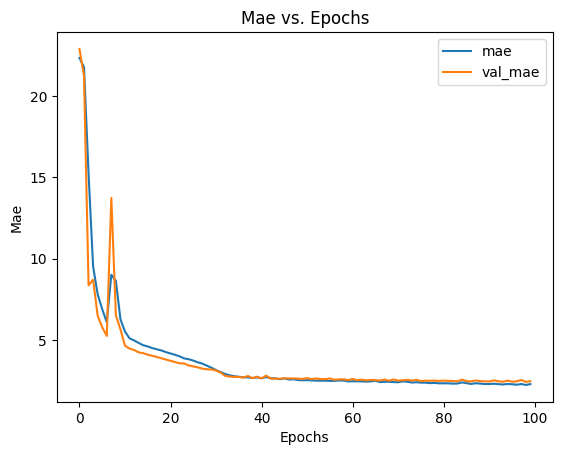

In [40]:
ml_toolbox.analysis.history.plot_history(model_4_history, 'mae')

In [41]:
model_4_preds = model_4.predict(test_dataset)

model_4_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_test, tf.squeeze(model_4_preds), model_4_name)
model_4_results

4/4 [==============================] - 0s 929us/step


RegressionPredictionMetrics(mae=2.4575236, mse=13.989126, rmse=3.740204, mape=10.972673, mase=0.25638866, huber=2.0067263, name='model_4_pruned_dnn')

### Experiment-5: Learning Rate Analysis of Pruned DNN

In [42]:
# Constants
model_5_name = 'model_5_lr_analysis'

INITIAL_LEARNING_RATE = 0.0001
DECAY_FACTOR = 10
DECAY_STEP = 20
EPOCHS = 100

In [43]:
# Learning Rate Decay Function
exponential_decay_function = ml_toolbox.modeling.learning_rate.generate_exponential_decay_function(
    initial_learning_rate=INITIAL_LEARNING_RATE,
    decay_factor=DECAY_FACTOR,
    decay_step=DECAY_STEP)

In [44]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

# Build Model
inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,))

x = inputs
for _ in range(NUM_HIDDEN_LAYERS_2):
    x = tfmot.sparsity.keras.prune_low_magnitude(tf.keras.layers.Dense(NUM_NEURONS_PER_HIDDEN_2, activation='relu'))(x)

outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='relu')(x)

model_5 = tf.keras.models.Model(inputs, outputs, name=model_5_name)

# Compile Model
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

# Fit Model
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(exponential_decay_function)
model_5_history = model_5.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=EPOCHS,
                              callbacks=[
                                  tf.keras.callbacks.LearningRateScheduler(exponential_decay_function),
                                  tfmot.sparsity.keras.UpdatePruningStep(),
                                  tfmot.sparsity.keras.PruningSummaries(log_dir='./logs/pruning/'),
                              ])

Epoch 1/100
13/13 [==============================] - 2s 13ms/step - loss: 22.3892 - mae: 22.3892 - mse: 587.8049 - val_loss: 23.0702 - val_mae: 23.0702 - val_mse: 607.9238 - lr: 1.0000e-04
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 22.3771 - mae: 22.3771 - mse: 587.2620 - val_loss: 23.0561 - val_mae: 23.0561 - val_mse: 607.2712 - lr: 1.1220e-04
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 22.3604 - mae: 22.3604 - mse: 586.5166 - val_loss: 23.0358 - val_mae: 23.0358 - val_mse: 606.3391 - lr: 1.2589e-04
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 22.3355 - mae: 22.3355 - mse: 585.4020 - val_loss: 23.0039 - val_mae: 23.0039 - val_mse: 604.8699 - lr: 1.4125e-04
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 22.2926 - mae: 22.2926 - mse: 583.4965 - val_loss: 22.9436 - val_mae: 22.9436 - val_mse: 602.1124 - lr: 1.5849e-04
Epoch 6/100
13/13 [==============================] - 0s 2ms

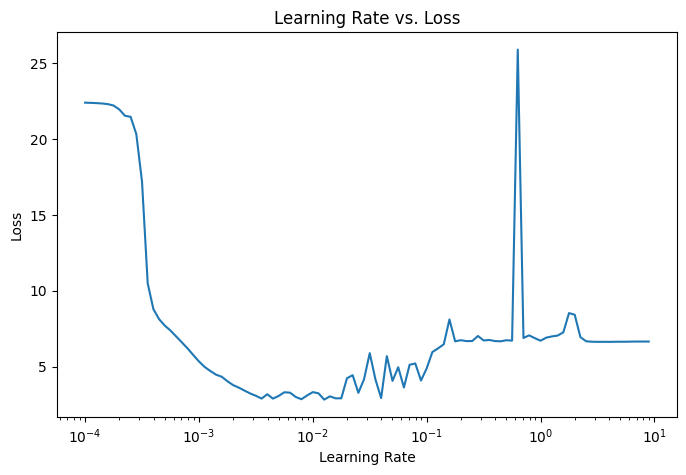

In [45]:
# Loss vs epoch
# Plot learning rate versus the loss
lrs = tf.convert_to_tensor([exponential_decay_function(x) for x in tf.range(EPOCHS)])
ml_toolbox.analysis.history.plot_learning_rate_versus_loss(lrs, model_5_history.history['loss'], figsize=(8, 5))

#### Findings

After running through the learning rate analysis of the pruned model, it appears an initial learning rate is somewhere between `1.26e-3` - `1.26e-2`.

### Experiment-6: Pruned Deep Neural Network, Optimized Learning Rate, w/ Non-Linear Activation

In [53]:
# Constants
model_6_name = 'model_6_pruned_dnn_opt'

OPTIMIZED_INITIAL_LEARNING_RATE = 0.003

In [59]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

# Build Model
inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,))

x = inputs
for _ in range(NUM_HIDDEN_LAYERS_2):
    x = tfmot.sparsity.keras.prune_low_magnitude(tf.keras.layers.Dense(NUM_NEURONS_PER_HIDDEN_2, activation='relu'))(x)

outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='relu')(x)

model_6 = tf.keras.models.Model(inputs, outputs, name=model_6_name)

# Compile Model
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=OPTIMIZED_INITIAL_LEARNING_RATE),
                metrics=['mae', 'mse'])

# Fit Model
learning_rate_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-5)
model_6_history = model_6.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=EPOCHS,
                              callbacks=[
                                  learning_rate_plateau_callback,
                                  tfmot.sparsity.keras.UpdatePruningStep(),
                                  tfmot.sparsity.keras.PruningSummaries(log_dir='./logs/pruning/'),
                              ])

Epoch 1/100
13/13 [==============================] - 3s 14ms/step - loss: 21.7185 - mae: 21.7185 - mse: 558.4444 - val_loss: 18.1729 - val_mae: 18.1729 - val_mse: 408.5499 - lr: 0.0030
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 11.1051 - mae: 11.1051 - mse: 195.0425 - val_loss: 9.9668 - val_mae: 9.9668 - val_mse: 163.5014 - lr: 0.0030
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 8.1655 - mae: 8.1655 - mse: 116.0459 - val_loss: 6.7012 - val_mae: 6.7012 - val_mse: 87.2029 - lr: 0.0030
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 6.3296 - mae: 6.3296 - mse: 78.0298 - val_loss: 5.0790 - val_mae: 5.0790 - val_mse: 47.2381 - lr: 0.0030
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 5.3684 - mae: 5.3684 - mse: 58.7137 - val_loss: 5.4627 - val_mae: 5.4627 - val_mse: 46.4344 - lr: 0.0030
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 4.7992 - mae: 4.7992 - ms

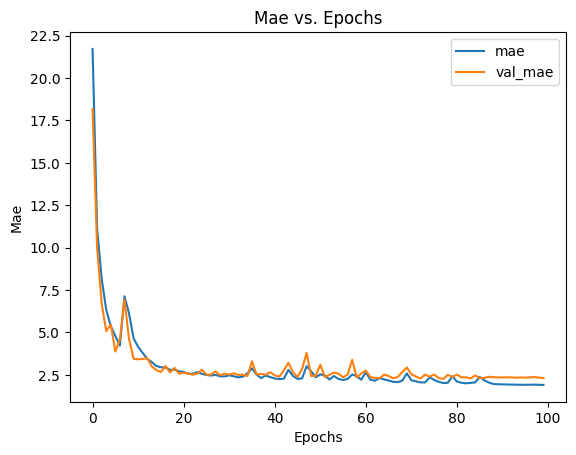

In [60]:
ml_toolbox.analysis.history.plot_history(model_6_history, 'mae')

In [61]:
model_6_preds = model_6.predict(test_dataset)

model_6_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_test, tf.squeeze(model_6_preds), model_6_name)
model_6_results

4/4 [==============================] - 0s 852us/step


RegressionPredictionMetrics(mae=2.3166783, mse=11.661828, rmse=3.4149418, mape=11.103387, mase=0.24169455, huber=1.8651465, name='model_6_pruned_dnn_opt')

## Analysis

### Model Comparison

In [57]:
all_results = [
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results,
    model_4_results,
    model_6_results,
]

all_results_df = ml_toolbox.analysis.regression.generate_prediction_metrics_dataframe(all_results)
all_results_df

,mae,mse,rmse,mape,mase,huber
model_0_simple,4.285635,40.747131,6.383348,17.530329,0.447112,3.816541
model_1_single_hidden_relu,4.823767,52.500267,7.245707,19.291233,0.503254,4.363771
model_2_deep_net,2.600976,15.603518,3.950129,11.599134,0.271355,2.165684
model_3_skip_nn,2.558352,12.519767,3.538328,11.712883,0.266908,2.107871
model_4_pruned_dnn,2.457524,13.989126,3.740204,10.972673,0.256389,2.006726
model_6_pruned_dnn_opt,2.316678,11.661828,3.414942,11.103387,0.241695,1.865147


<Axes: >

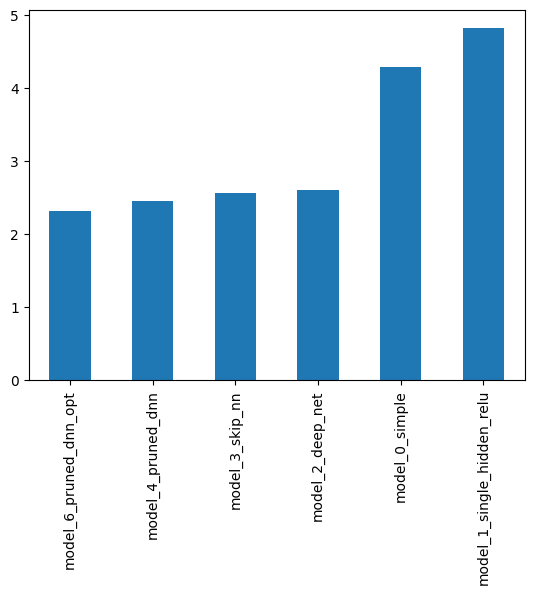

In [58]:
all_results_df['mae'].sort_values().plot(kind='bar')

### Findings

After comparing each model, it appears that model_4 resulted in the lowest `MAE`.

### Export

In [156]:
ml_toolbox.analysis.model.export_and_verify_model(model_4,
                                                  test_dataset,
                                                  'mae',
                                                  strip_pruning=True,
                                                  file_type='h5')

INFO:root:Original Model Evaluation Metrics: [2.3394529819488525, 2.3394529819488525, 12.509822845458984]
INFO:root:Model Metrics to Compare: ['loss', 'mae', 'mse']
INFO:root:Saving Model to: ./models/model_4_pruned_dnn.h5
INFO:root:Loading Model from: ./models/model_4_pruned_dnn.h5


/Users/brandonkubick/Code/deep-learning-development/env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:root:Loaded Model Evaluation Metrics: [2.3394529819488525, 2.3394529819488525, 12.509822845458984]


True